In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

In [2]:
mempoolHourly <- fread("mempool_hourly.tsv.gz", stringsAsFactors=TRUE)
mempoolHourly %>% summary

            region        hour                        tx_seen_first
 ap-northeast-1: 2   Min.   :2025-11-19 21:00:00.00   f:45         
 eu-central-1  :78   1st Qu.:2025-11-20 08:00:00.00   t:40         
 us-central-2  : 5   Median :2025-11-20 18:00:00.00                
                     Mean   :2025-11-20 18:56:28.24                
                     3rd Qu.:2025-11-21 05:00:00.00                
                     Max.   :2025-11-21 17:00:00.00                
    tx_count       tx_fraction      
 Min.   :   2.0   Min.   :0.001448  
 1st Qu.:  12.0   1st Qu.:0.010320  
 Median : 605.0   Median :0.883062  
 Mean   : 773.4   Mean   :0.541176  
 3rd Qu.:1278.0   3rd Qu.:0.991263  
 Max.   :5138.0   Max.   :1.000000  

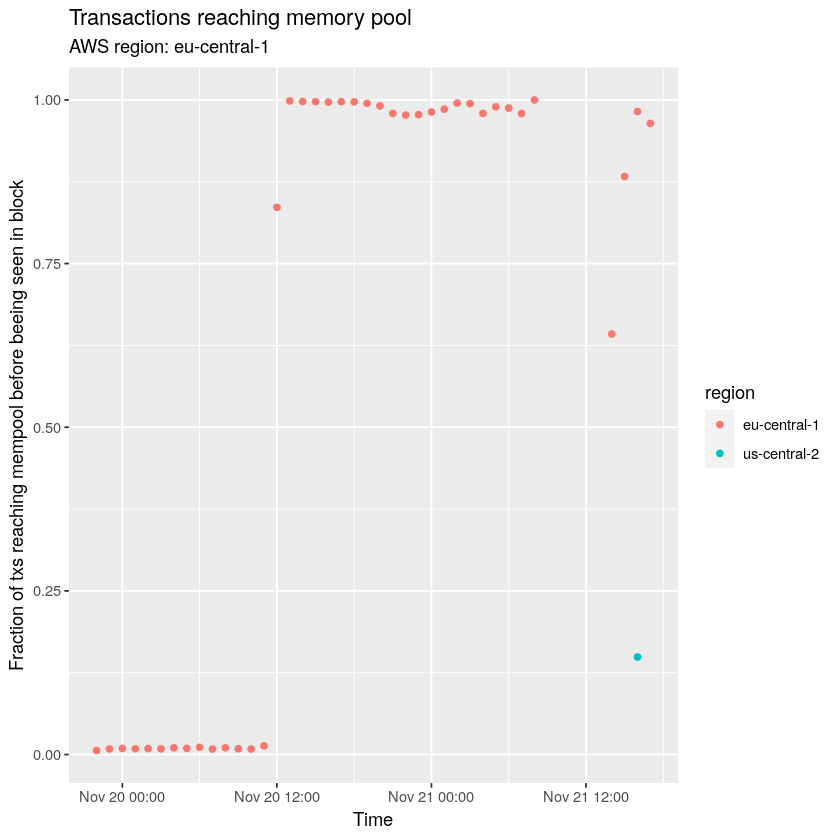

In [3]:
ggplot(mempoolHourly[`tx_seen_first` == "t"], aes(x=`hour`, y=`tx_fraction`, color=`region`)) +
    geom_point() +
    xlab("Time") +
    ylab("Fraction of txs reaching mempool before beeing seen in block") +
    ggtitle(
        "Transactions reaching memory pool",
        "AWS region: eu-central-1"
    )

In [4]:
ggsave("mempool_hourly.png", units="in", dpi=150, width=8, height=6)

In [5]:
mempoolHistory <- fread("mempool_history.tsv.gz", stringsAsFactors=TRUE)
mempoolHistory %>% summary

            region        slot_no          tx_seen_first    tx_count     
 ap-northeast-1: 300   Min.   :172020832   f:3012        Min.   :  1.00  
 eu-central-1  :6041   1st Qu.:172056250   t:3532        1st Qu.:  3.00  
 us-central-2  : 203   Median :172091273                 Median :  6.00  
                       Mean   :172092342                 Mean   : 10.05  
                       3rd Qu.:172126077                 3rd Qu.: 13.00  
                       Max.   :172179780                 Max.   :122.00  

In [6]:
mempoolHistory[, `tx_fraction` := as.numeric(`tx_count`) / sum(`tx_count`), by =.(`region`, `slot_no`)]

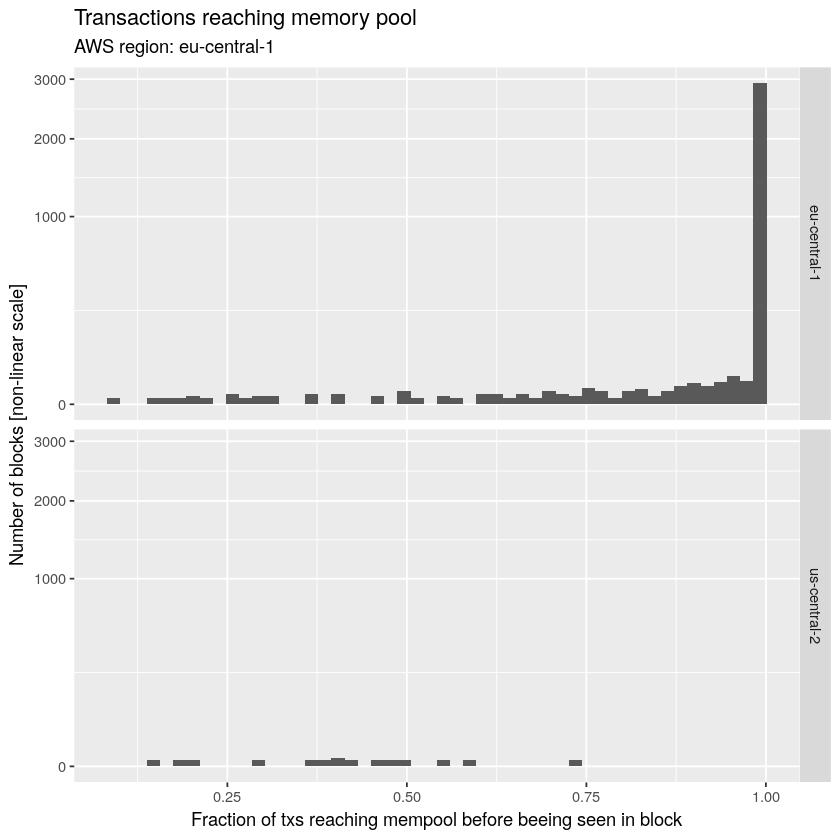

In [7]:
ggplot(mempoolHistory[`slot_no` >= 172095067 - 4 * 3600 & `tx_seen_first` == "t"], aes(x=`tx_fraction`)) +
    geom_histogram(bins=50) +
    scale_y_sqrt() +
    facet_grid(`region` ~ .) +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks [non-linear scale]") +
    ggtitle(
        "Transactions reaching memory pool",
        "AWS region: eu-central-1"
    )

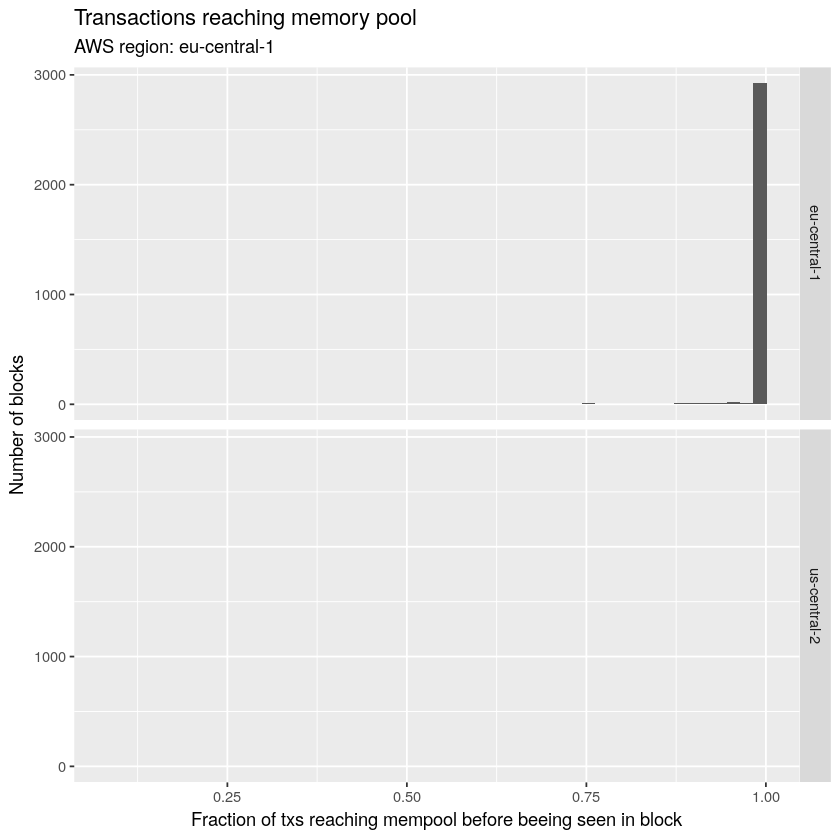

In [8]:
ggplot(mempoolHistory[`slot_no` >= 172095067 - 4 * 3600 & `tx_seen_first` == "t"], aes(x=`tx_fraction`)) +
    geom_histogram(bins=50) +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks") +
    facet_grid(`region` ~ .) +
    ggtitle(
        "Transactions reaching memory pool",
        "AWS region: eu-central-1"
    )

In [9]:
ggsave("mempool_history.png", units="in", dpi=150, width=8, height=6)

In [10]:
mempoolBlocks <- fread("mempool_vs_blocks.tsv.gz", stringsAsFactors=TRUE)
mempoolBlocks %>% summary

            region         slot_no         
 ap-northeast-1: 5650   Min.   :172020832  
 eu-central-1  :55444   1st Qu.:172074271  
 us-central-2  : 4642   Median :172106548  
                        Mean   :172106278  
                        3rd Qu.:172142707  
                        Max.   :172179780  
                                           
                                                            block_hash   
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:  237  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:  224  
 ad8c59a6ae59ad5c49071cd49a8a21944555cbdbc695d9c47c4081bbb78fe78a:  183  
 fb40a3b7b7345173b8fcaa6799c653ee6c4db821407b57598cfb3cc076b59686:  177  
 10fe42ba07c542e7152d958496d767e8244556bee5725324b0aec852ff325b7f:  168  
 9d12288c5097879998102336ea21b693d24f6bab1fa51a81c80c928de5e78242:  168  
 (Other)                                                         :64579  
                                                        

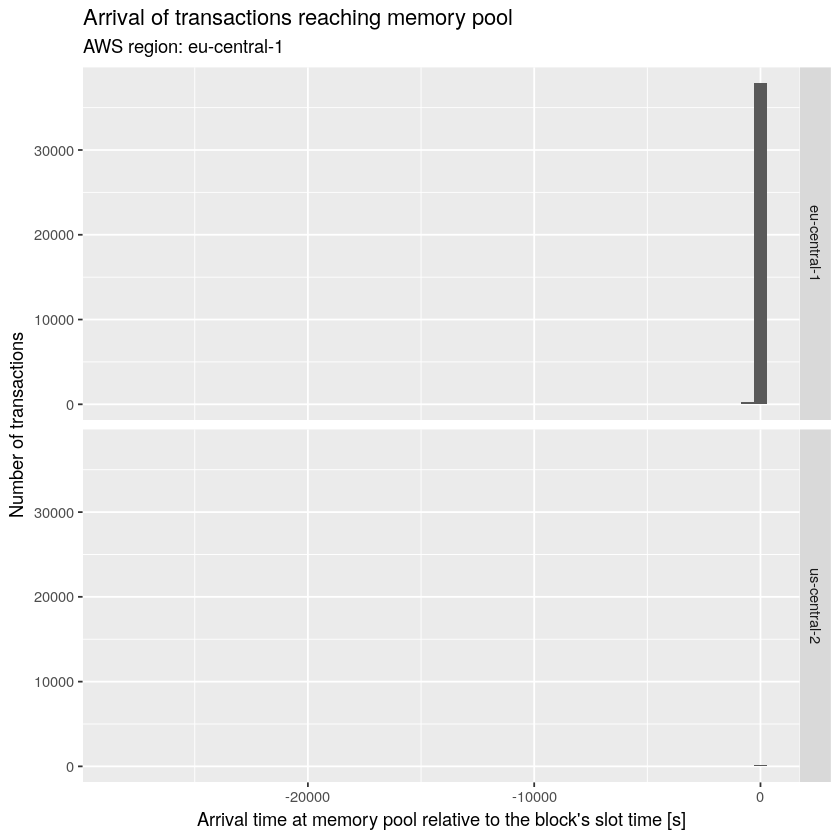

In [11]:
ggplot(mempoolBlocks[`tx_seen_first` == "t"], aes(x=`mempool_minus_slot`)) +
    geom_histogram(bins=50) +
    facet_grid(`region` ~ .) +
    xlab("Arrival time at memory pool relative to the block's slot time [s]") +
    ylab("Number of transactions") +
    ggtitle(
        "Arrival of transactions reaching memory pool",
        "AWS region: eu-central-1"
    )

In [12]:
ggsave("transaction_arrival.png", units="in", dpi=150, width=8, height=6)

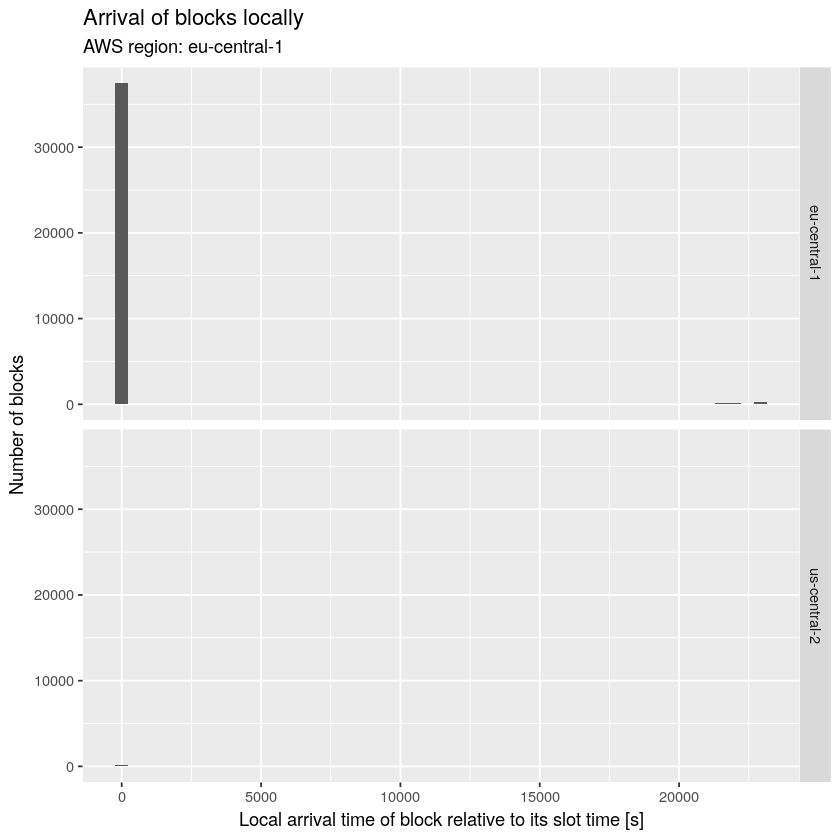

In [13]:
ggplot(mempoolBlocks[`tx_seen_first` == "t"], aes(x=`block_minus_slot`)) +
    geom_histogram(bins=50) +
    facet_grid(`region` ~ .) +
    xlab("Local arrival time of block relative to its slot time [s]") +
    ylab("Number of blocks") +
    ggtitle(
        "Arrival of blocks locally",
        "AWS region: eu-central-1"
    )

In [14]:
ggsave("block_arrival.png", units="in", dpi=150, width=8, height=6)